#캡스톤 시계열 예측

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import math as m
import keras
from keras.models import save_model, load_model
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, Lambda, Reshape, Input
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class preprocessing():

  def __init__(self, path, train_width, label_width, target = None,
               train_features = None, shift = None):
    
    print('\n\ninput data shape = (num_features, dataset_interation, row, col)\n')
    print('LSTM input layers get multi-inputs\n\n')

    df = pd.read_csv(path)
    df.drop(['Unnamed: 0', 'datetime'], axis = 1, inplace = True)
    self.target = target
    self.train_features = train_features
    self.train_width = train_width
    self.label_width = label_width

    if self.target is None:
      raise ValueError('self.target must be entered')
    
    if self.train_features is None:
      print('self.train_features is None')
      self.X_df = pd.DataFrame(df.drop([self.target], axis = 1))
      self.Y_df = pd.DataFrame(df[self.target])
    else:
      print('self.train_features : ', self.train_features)
      self.X_df = pd.DataFrame(df[self.train_features])
      self.Y_df = pd.DataFrame(df[self.target])
    
    if shift is not None:
      self.shift = shift
    else:
      self.shift = 1

    print('X_df info : ', self.X_df.info())
    print('Y_df info : ', self.Y_df.info())

    X_train_df, X_val_df, X_test_df = self.splitDataSet(self.X_df)
    Y_train_df, Y_val_df, Y_test_df = self.splitDataSet(self.Y_df)

    X_train_Df, X_val_Df, X_test_Df = self.Data_normalization(X_train_df,X_val_df, X_test_df)
    Y_train_Df, Y_val_Df, Y_test_Df = self.Data_normalization(Y_train_df, Y_val_df, Y_test_df)

    self.X_train_Df = pd.DataFrame(X_train_Df)
    self.Y_train_Df = pd.DataFrame(Y_train_Df)
    self.X_val_Df = pd.DataFrame(X_val_Df)
    self.Y_val_Df = pd.DataFrame(Y_val_Df)
    self.X_test_Df = pd.DataFrame(X_test_Df)
    self.Y_test_Df = pd.DataFrame(Y_test_Df)

    self.X_train_Df.columns = train_features
    self.Y_train_Df.columns = [target]
    self.X_val_Df.columns = train_features
    self.Y_val_Df.columns = [target]
    self.X_test_Df.columns = train_features
    self.Y_test_Df.columns = [target]

    self.num_features = self.X_train_Df.shape[1]+1 # +1 for Y_DF added to X_DF

    #print('print Df shape\n')
    #print('X_train_Df : ', X_train_Df.shape)
    #print('Y_train_Df : ', Y_train_Df.shape)
    #print('X_val_Df : ', X_val_Df.shape)
    #print('Y_val_Df : ', Y_val_Df.shape)
    #print('X_test_Df : ', X_test_Df.shape)
    #print('Y_test_Df : ', Y_test_Df.shape)

#===============================================================================

  """
  Cuting the dataset accoding to a threshold risks eliminating the time seires characteristic of the data.
  So it might be better not to use it.
  """ 

  def cut_threshold(self, threshold = None, total_capacity = None, unit = None):
    if threshold is None:
      threshold = 0.1
    if total_capacity is None:
      total_capacity = 500*10**6
    if unit is None:
      unit = 1000

    threshold = total_capacity * threshold / unit
    df_train_th = self.df_train[self.df_train >= threshold]
    df_label_th = self.df_label[self.df_label >= threshold]
    
    print('df_train_th info : ', df_train_th.info())
    print('df_label_th info : ', df_label_th.info())
    return df_train_th, df_label_th

#===============================================================================

  def splitDataSet(self, df):
    le = len(df)
    train_df = df[0:int(le*0.7)]
    val_df = df[int(le*0.7):int(le*0.9)]
    test_df = df[int(le*0.9):]
    return train_df, val_df, test_df

  def Data_normalization(self, train_df, val_df, test_df):
    self.sc1 = MinMaxScaler(feature_range=(0,1))
    train_df = self.sc1.fit_transform(train_df)
    self.sc2 = MinMaxScaler(feature_range=(0,1))
    val_df = self.sc2.fit_transform(val_df)
    self.sc3 = MinMaxScaler(feature_range=(0,1))
    test_df = self.sc3.fit_transform(test_df)

    self.train_df = pd.DataFrame(train_df)
    self.val_df = pd.DataFrame(val_df)
    self.test_df = pd.DataFrame(test_df)
    return train_df, val_df, test_df

#===============================================================================
  def makeDataSet(self, df_x, df_y):
    #df_x <= train_features dataset without target column
    #df_y <= Y_train_Df dataset with target only

    Y_DF = pd.DataFrame(df_y)
    X_DF = pd.DataFrame(df_x)

    #print('X_DF.shape : ',X_DF.shape)
    #print('Y_DF.shape : ',Y_DF.shape)

    X_DF_in = pd.concat([X_DF, Y_DF], axis = 1)
    self.iter_features = X_DF_in.columns
    #print(self.iter_features)

    #print('X_DF_in.shape : ', X_DF_in.shape)
    #Y_DF = X_DF

    epochs = m.trunc((Y_DF.shape[0] - self.train_width - self.label_width) / self.shift)

    X_df = []
    for feature in self.iter_features:
      print(feature)
      X_df.append(self.XSet_implementation(X_DF_in[feature], epochs))
    
    Y_df = self.YSet_implementation(Y_DF, epochs)


    X_df = np.array(X_df)
    Y_df = np.array(Y_df)

    self.X_row = X_df.shape[1]
    self.X_col = X_df.shape[2]

    return X_df, Y_df

  def XSet_implementation(self, df_iloc, epochs):
    df_append = []
    for i in range(epochs):
        df_append.append((df_iloc.iloc[self.shift*i : self.shift*i + self.train_width]))
    df_append = np.array(df_append)
    #print(df_append.shape)
    return df_append

  def YSet_implementation(self, df_iloc, epochs):
    df_append = []
    for i in range(epochs):
      df_append.append(df_iloc.iloc[self.shift*i + self.train_width : self.shift*i + self.train_width + self.label_width])
    return df_append

#===============================================================================

  def plotDataSet(self):
    X_train, Y_train = self.makeDataSet(self.X_train_Df, self.Y_train_Df)
    axx = np.arange(0, self.train_width)
    axy = np.arange(self.train_width, self.train_width + self.label_width, 1)
    
    for i in range(1,5):
      plt.figure(figsize=(20,10))
      plt.subplot(2,2,i)
      
      for j in range(len(self.iter_features)-1):
        plt.plot(axx, X_train[j][i])

      if len(Y_train[0]) > 1:
        plt.plot(axy, Y_train[i], c='r')
      else:
        plt.scatter(axy, Y_train[i], c = 'r')
      plt.show()

  @property
  def train(self):
    return self.makeDataSet(self.X_train_Df, self.Y_train_Df)

  @property
  def val(self):
    return self.makeDataSet(self.X_val_Df, self.Y_val_Df)

  @property
  def test(self):
    return self.makeDataSet(self.X_test_Df, self.Y_test_Df)

  @property
  def sc_train(self):
    return self.sc1

  @property
  def sc_val(self):
    return self.sc2

  @property
  def sc_test(self):
    return self.sc3  


In [ ]:
path = "/content/drive/MyDrive/발전예측/2ndSpline/df_2020_lstm.csv"

In [ ]:
p1 = preprocessing(path, 12*24*3, 12*24, 'sunlight', ['Day cos', 'Day sin', 'insolation', 'humidity', 'temperature', 'wind_speed'], 12*24)



input data shape = (num_features, dataset_interation, row, col)

LSTM input layers get multi-inputs


self.train_features :  ['Day cos', 'Day sin', 'insolation', 'humidity', 'temperature', 'wind_speed']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105408 entries, 0 to 105407
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Day cos      105408 non-null  float64
 1   Day sin      105408 non-null  float64
 2   insolation   105408 non-null  float64
 3   humidity     105408 non-null  float64
 4   temperature  105408 non-null  float64
 5   wind_speed   105408 non-null  float64
dtypes: float64(6)
memory usage: 4.8 MB
X_df info :  None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105408 entries, 0 to 105407
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   sunlight  105408 non-null  float64
dtypes: float64(1)
memory usage: 823.6 KB
Y_df info :

Day cos
Day sin
insolation
humidity
temperature
wind_speed
sunlight


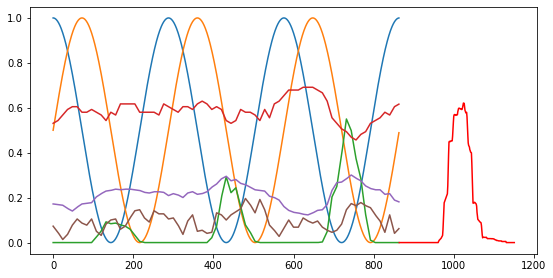

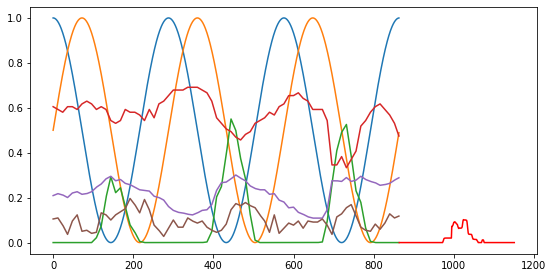

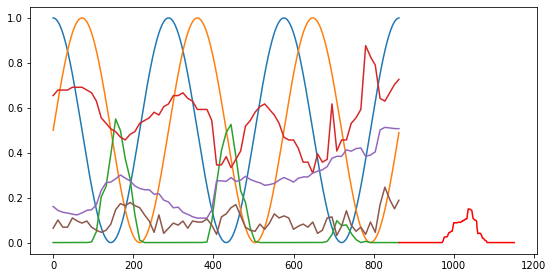

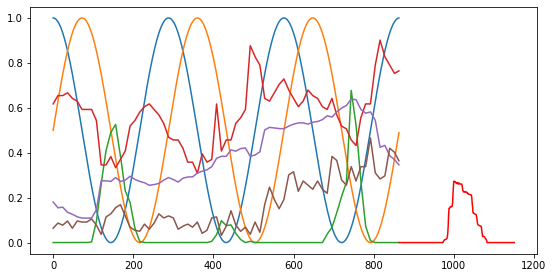

In [ ]:
p1.plotDataSet()

In [ ]:
class model_processing():
  def __init__(self, selected_model, conv_width, preprocessing_instance):
    self.selected_model = selected_model
    self.conv_width = conv_width
    self.instance = preprocessing_instance
    self.out_steps = self.instance.label_width
    self.num_features = self.instance.num_features

    if self.selected_model == 'conv':
      print('Convolution model selected')
    elif self.selected_model == 'AR':
      print('AuroRegression model selected')
    elif self.selected_model == 'LSTM':
      print('LSTM model selected')
    else:
      raise ValueError('Unsupported model')
  
  def AR(self):
    model = Sequential()
    model.add(LSTM())


    return model

  def conv(self):
    model = Sequential()
    model.add(Lambda(lambda x: x[:, -self.conv_width:, :]))
    model.add(Conv1D(256, activation = 'relu', kernel_size = self.conv_width))
    model.add(Dense(self.out_steps * self.num_features,
                    kernel_initializer=tf.initializers.zeros))
    model.add(Reshape([self.out_steps, self.num_features]))

    return model

  def LSTM_func_with_fcst(self):

    # sequence of train set
    # input1 : Day cos
    # input2 : Day sin
    # input3 : insolation
    # input4 : humidity
    # input5 : temperature
    # input6 : wind_speed
    # input7 : sunlight

    input = {}
    for i in range(self.instance.num_features):
      input[i] = Input(shape = (self.instance.X_row, self.instance.X_col))

    #after test


  def LSTM_func_only_target(self):
    input_layer = Input(shape = (self.instance.train_width, self.instance.num_features)) #instance.num_features must be 1
    x = LSTM(32, activation = 'tanh', return_sequences = True)(input_layer)
    x = Dropout(0.2)(x)
    x = LSTM(32, activation = 'relu', return_sequences = True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(32, activation = 'relu', return_sequences = False)(x)
    x = Dropout(0.2)(x)
    x = Dense(self.instance.label_width * self.num_features,
              kernel_initializer = tf.initializers.zeros)(x)
    outputs = Reshape([self.instance.label_width, self.num_features])(x)

    model = Model(inputs = input_layer, outputs = outputs)

    return model

  def LSTM_seq(self):
    
    model = Sequential([LSTM(32, activation = 'sigmoid', return_sequences= True),
                        Dropout(0.2),
                        LSTM(32, activation = 'sigmoid', return_sequences= True),
                        Dropout(0.2),
                        LSTM(32, activation = 'sigmoid', return_sequences= False),
                        Dropout(0.2),
                        Dense(self.instance.label_width * self.num_features,
                              kernel_initializer = tf.initializers.zeros),
                        Reshape([self.instance.label_width, self.num_features])
                        

    ])
    
    #model.add(LSTM(32, activation = 'sigmoid', return_sequences= True))
    #model.add(Dropout(0.2))
    #model.add(LSTM(32, activation = 'sigmoid', return_sequences= True))
    #model.add(Dropout(0.2))
    #model.add(LSTM(32, activation = 'sigmoid', return_sequences= False))
    #model.add(Dropout(0.2))
    #model.add(Dense(self.instance.label_width * self.num_features,
    #                kernel_initializer = tf.initializers.zeros))
    #model.add(Reshape([self.instance.label_width, self.num_features]))

    return model

  def train (self):
    if self.selected_model == 'conv':
      model = self.conv()

    elif self.selected_model == 'AR':
      model = self.AR()

    elif self.selected_model == 'LSTM':
      model = self.LSTM_func()
    
    with tf.device('/gpu:0'):# comment out when running in a local enviroment
      hitory = self.compile_and_fit(model)

#===============================================================================

  def compile_and_fit(self, model):
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer = tf.optimizers.Adam(),
                  metrics = [tf.metrics.MeanAbsoluteError()])
    

    with tf.device('/gpu:0'):
      history = model.fit(self.instance.train, epochs=15, batch_size = 10)
    return history

  def compile_and_fit_with_callback(self, model, patience=2, MAX_EPOCHS = 20):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer = tf.optimizers.Adam(),
                  metrics = [tf.metrics.MeanAbsoluteError()])
    

    with tf.device('/gpu:0'):
      history = model.fit(self.instance.train, epochs=MAX_EPOCHS,
                          validation_data = (self.instance.val),
                          callbacks = [early_stopping])
    return history

#===============================================================================

  def inverse_transform(self, pred, val = None, test = None):
    if (val is not None) & (test is not None):
      raise ValueError('enter only validation set or test set')
    elif val is not None:
      pred_original = self.instance.sc_val().inverse_transform(pred)
      Y_orginal = self.instance.sc_val().inverse_transform(val.reshape(-1,1))
    elif test is not None:
      pred_original = self.instance.sc_test().inverse_transform(pred)
      Y_orginal = self.instance.sc_test().inverse_transform(test.reshape(-1,1))
    else:
      raise ValueError('enter at least one dataset')
    
    return pred_original, Y_orginal

#===============================================================================

  def printPlot(self, pred, Y_df):
    plt.figure(figsize = (20,10))
    plt.title('Prediction and True data graph')
    plt.plot(Y_df[0], c = 'g', label = 'True')
    plt.plot(pred, c = 'r', label = 'Pred')
    plt.legend()
    plt.show()

#===============================================================================

  def Electricity_market_Error(self, pred_or, Y_val_or):
    error = []
    Y_val_or = pd.DataFrame(Y_val_or)
    for i in range(len(Y_val_or)):
      error = error + [(abs(Y_val_or.reset_index(drop=True)[0][i] - pred_or[i]))/(491.8*1000)*100]

    ax = np.linspace(0,len(Y_val_or),len(Y_val_or))
    #plt.scatter(ax, error, c = 'b')
    plt.plot(ax, error, c = 'r')
    plt.title('Error - Percentage')
    plt.xlabel('5minute')
    plt.ylabel('Percentage')
    plt.show()

    mean_error = (sum(error)/len(error))
    print('\n\nVal_set Mean Error-Percentage : {0:0.4f} %'.format((mean_error[0])))

SyntaxError: ignored

#Data input
    X_test = X_train[i].T
    X_test = X_test.reshape(-1, X_test.shape[i], 1)

In [ ]:
m1 = model_processing('LSTM',3,p1)

LSTM model selected


#내 코드에서
###ValueError: Layer "model_2" expects 1 input(s), but it received 2 input tensors. Inputs received:
###[<tf.Tensor 'IteratorGetNext:0' shape=(None, 864, 7) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 288, 1) dtype=float32>]

#TF 예제에서
###Tensor("strided_slice:0", shape=(None, None, 19), dtype=float32)
###Tensor("strided_slice_1:0", shape=(None, None, 19), dtype=float32)

#아이디어
LSTM의 Inputs을 multi input으로 만들고 중간에 합치면 되지 않을까?

<funtional api에서>

tanh랑 relu를 섞어 쓰는 것이 가장 좋더라 - 이호준 선배님

#모델 앙상블


###LGBM

In [ ]:
import lightgbm as lgb
bst0 = lgb.Booster(model_file = '/content/drive/MyDrive/발전예측/mode.txt/mode0_1h.txt')
bst1 = lgb.Booster(model_file = '/content/drive/MyDrive/발전예측/mode.txt/mode1_1h.txt')
bst2 = lgb.Booster(model_file = '/content/drive/MyDrive/발전예측/mode.txt/mode2_1h.txt')
bst3 = lgb.Booster(model_file = '/content/drive/MyDrive/발전예측/mode.txt/mode3_1h.txt')